# Use reverse sigmoid as the gradient for back propgation
Chao Zhang

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
np.random.seed(0)
lr = 0.05
epochs = 100000

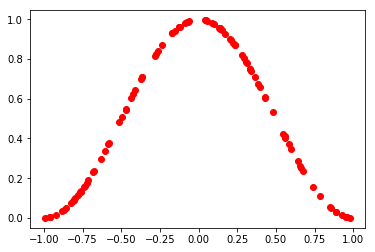

In [3]:
x = np.random.uniform(low=-1.0, high=1.0, size=(1,100))
y = (np.cos(x*np.pi) + 1)/2
#y = x**2
plt.plot(x.T,y.T,'ro')

### To make things clear, the entire neural network will be written only with numpy

In [4]:
architecture = (1,2,2,1)

def initialize(architecture, seed = 0):
    np.random.seed(seed)
    number_of_layers = len(architecture) - 1
    params_values = {}
    
    for idx in range(1, len(architecture)):
        layer_input_size = architecture[idx-1]
        layer_output_size = architecture[idx]
        
        params_values['W' + str(idx)] = np.random.randn(layer_output_size, layer_input_size) * 0.1
        params_values['b' + str(idx)] = np.random.randn(layer_output_size, 1) * 0.1
        
    return params_values

In [5]:
def sigmoid(Z):
    return 1/(1+np.exp(-Z))

def rev_sigmoid(s):
    return -np.log(1/s-1)

def sigmoid_backward(dA, Z):
    sig = sigmoid(Z)
    return dA * sig * (1 - sig)

def sigmoid_backward_inverse(dA, Z, learning_rate=lr):    
    sig = sigmoid(Z)
    
    delta = dA*learning_rate
    sig_updated =  np.clip(sig - delta, a_min=1e-9, a_max=1-1e-9)

    #assert (0<sig_updated).all() and (sig_updated<1).all()
    Z_updated = rev_sigmoid(sig_updated)
    
    s_z = delta/(Z-Z_updated)

    return dA * s_z

In [6]:
def single_layer_forward_propagation(A_prev, W_curr, b_curr):
    Z_curr = np.dot(W_curr, A_prev) + b_curr
  
    return sigmoid(Z_curr), Z_curr

def full_forward_propagation(X, params_values, architecture):
    memory = {}
    z_history = []
    A_curr = X
    
    for idx, layer in enumerate(architecture[1:]):
        idx += 1
        A_prev = A_curr
        
        W_curr = params_values["W" + str(idx)]
        b_curr = params_values["b" + str(idx)]
        A_curr, Z_curr = single_layer_forward_propagation(A_prev, W_curr, b_curr)
        
        memory["A" + str(idx-1)] = A_prev
        memory["Z" + str(idx)] = Z_curr
        z_history.append(Z_curr)
       
    return A_curr, memory, z_history

In [7]:
def get_cost_value(Y_hat, Y):
    assert Y_hat.shape == Y.shape, (Y_hat.shape, Y.shape)
    cost = np.mean((Y_hat-Y)**2)
    return np.squeeze(cost)

In [8]:
def single_layer_backward_propagation(dA_curr, W_curr, b_curr, Z_curr, A_prev, method="default"):
    m = A_prev.shape[1]
    
    if method is "inverse":
        backward_activation_func = sigmoid_backward_inverse
    elif method is "default":
        backward_activation_func = sigmoid_backward
    else:
        raise Exception('Non-supported back propagation function')
    
    dZ_curr = backward_activation_func(dA_curr, Z_curr)
    dW_curr = np.dot(dZ_curr, A_prev.T) / m
    db_curr = np.sum(dZ_curr, axis=1, keepdims=True) / m
    dA_prev = np.dot(W_curr.T, dZ_curr)

    return dA_prev, dW_curr, db_curr

In [9]:
def full_backward_propagation(Y_hat, Y, memory, params_values, architecture, method="default"):
    grads_values = {}
    m = Y.shape[1]
    Y = Y.reshape(Y_hat.shape)
   
    dA_prev = 2*(Y_hat - Y)
    
    for layer_idx_prev, layer in reversed(list(enumerate(architecture[1:]))):
        layer_idx_curr = layer_idx_prev + 1
        
        dA_curr = dA_prev
        
        A_prev = memory["A" + str(layer_idx_prev)]
        Z_curr = memory["Z" + str(layer_idx_curr)]
        W_curr = params_values["W" + str(layer_idx_curr)]
        b_curr = params_values["b" + str(layer_idx_curr)]
        
        dA_prev, dW_curr, db_curr = single_layer_backward_propagation(
            dA_curr, W_curr, b_curr, Z_curr, A_prev, method)
        
        grads_values["dW" + str(layer_idx_curr)] = dW_curr
        grads_values["db" + str(layer_idx_curr)] = db_curr
    
    return grads_values

In [10]:
def update(params_values, grads_values, architecture, learning_rate):
    for layer_idx in range(1, len(architecture)):
        params_values["W" + str(layer_idx)] -= learning_rate * grads_values["dW" + str(layer_idx)]        
        params_values["b" + str(layer_idx)] -= learning_rate * grads_values["db" + str(layer_idx)]

    return params_values;

In [11]:
def train(X, Y, architecture, epochs, learning_rate, method='default'):
    params_values = initialize(architecture)
    cost_history = []
    value_history = []
    batch_size = 10
    
    for i in range(epochs):
        batch_num = X.shape[1]//batch_size
        cost_i = 0
        for i in range(batch_num):
            x_i = X[:,i*batch_size:(i+1)*batch_size]
            y_i = Y[:,i*batch_size:(i+1)*batch_size]
            Y_hat, cashe, z_tmp = full_forward_propagation(x_i, params_values, architecture)
            cost_i += get_cost_value(Y_hat, y_i)

            grads_values = full_backward_propagation(Y_hat, y_i, cashe, params_values, architecture, method)
            params_values = update(params_values, grads_values, architecture, learning_rate)
        cost_history.append(cost_i/batch_num)
        Y_hat, cashe, z_tmp = full_forward_propagation(X, params_values, architecture)
        value_history.append(z_tmp)
    return params_values, cost_history, Y_hat, value_history

## Default back propagation

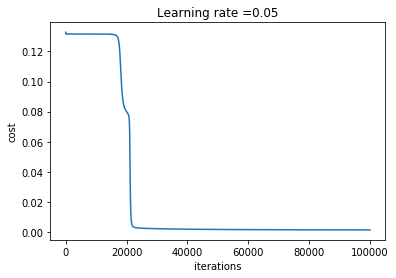

CPU times: user 5min 21s, sys: 1.4 s, total: 5min 23s
Wall time: 5min 22s


In [12]:
%%time
# small model
# architecture = (1,2,1)
params_values, cost_history, Y_hat, value_history = train(x,y, architecture, epochs, lr)
cost_0 = cost_history
value_0 = value_history
plt.plot(np.squeeze(cost_history))
plt.ylabel('cost')
plt.xlabel('iterations')
plt.title("Learning rate =" + str(lr))
plt.show()

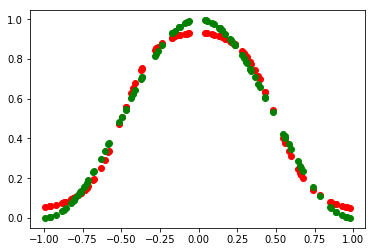

0.0013150541284886225


In [13]:
plt.plot(x.T,Y_hat.T,'ro')
plt.plot(x.T,y.T,'go')
plt.show()
print(cost_history[-1])

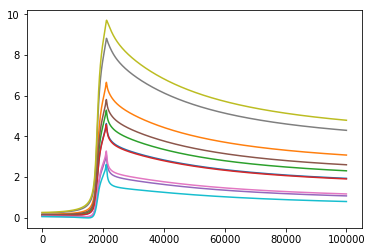

In [14]:
for i in range(10):
    plt.plot(np.array([x[0][0][i] for x in value_history]))

## Precise back Propagation

old: 0.0013150541284886225 new: 0.0012347518373843392


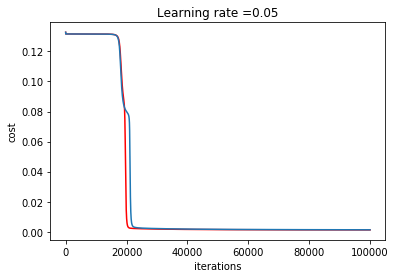

CPU times: user 6min 24s, sys: 1.36 s, total: 6min 25s
Wall time: 6min 25s


In [15]:
%%time
# small model
# architecture = (1,2,1)
params_values, cost_history, Y_hat, value_history = train(x,y, architecture, epochs, lr, method = 'inverse')
plt.plot(np.squeeze(cost_history), 'r')
plt.plot(np.squeeze(cost_0))
print('old:', cost_0[-1], 'new:', cost_history[-1])
plt.ylabel('cost')
plt.xlabel('iterations')
plt.title("Learning rate =" + str(lr))
plt.show()

old: 0.0013150541284886225 new: 0.0012347518373843392


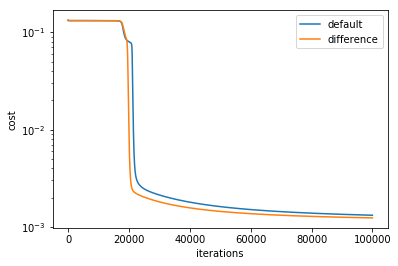

In [21]:
plt.yscale('log')
plt.plot(np.squeeze(cost_0), label = 'default')
plt.plot(np.squeeze(cost_history), label = 'difference')
print('old:', cost_0[-1], 'new:', cost_history[-1])
plt.ylabel('cost')
plt.xlabel('iterations')
#plt.title("Learning rate =" + str(lr))
plt.legend()
plt.savefig('convergence2.png', dpi=600)
plt.show()

0.0012347518373843392


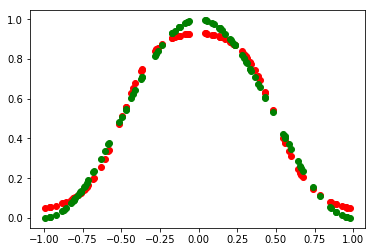

In [17]:
plt.plot(x.T,Y_hat.T,'ro')
plt.plot(x.T,y.T,'go')
print(cost_history[-1])

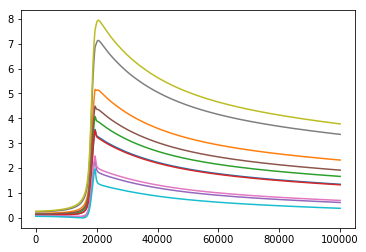

In [18]:
for i in range(10):
    plt.plot(np.array([x[0][0][i] for x in value_history]))

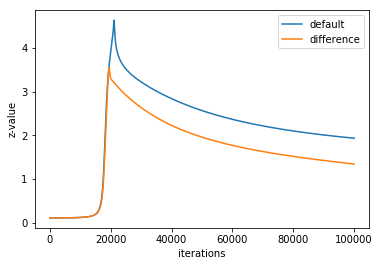

In [20]:

plt.plot(np.array([x[0][0][0] for x in value_0]), label = 'default')
plt.plot(np.array([x[0][0][0] for x in value_history]), label='difference')
plt.ylabel('z-value')
plt.xlabel('iterations')
plt.legend()
plt.savefig('z-value2.png', dpi=600)
plt.show()